In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
import copy

2024-11-08 08:34:23.768879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 08:34:23.935820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 08:34:23.936930: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 08:34:24.244420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 08:34:26.499595: W tensorflow/compiler/tf

In [4]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [4]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

KeyboardInterrupt: 

In [5]:
subset_paths = {'train': pathlib.Path('UCF101_subset/train'), 'val': pathlib.Path('UCF101_subset/val'), 'test': pathlib.Path('UCF101_subset/test')}

In [7]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

history_data = {'accuracy':[], 'loss':[], 'val_accuracy':[], 'val_loss':[]}

In [3]:
history_data = {'accuracy': [0.2142857164144516,
  0.31385281682014465,
  0.37012988328933716,
  0.4523809552192688,
  0.46536797285079956,
  0.5432900190353394,
  0.551948070526123,
  0.5757575631141663,
  0.6168830990791321,
  0.6082251071929932,
  0.6385281682014465,
  0.6515151262283325,
  0.6601731777191162,
  0.6839826703071594,
  0.7056276798248291,
  0.677489161491394,
  0.7294372320175171,
  0.7294372320175171,
  0.7186146974563599,
  0.738095223903656],
 'loss': [2.2236380577087402,
  1.9542049169540405,
  1.7800718545913696,
  1.5881649255752563,
  1.5647879838943481,
  1.381790041923523,
  1.31675386428833,
  1.2530393600463867,
  1.1656228303909302,
  1.1053072214126587,
  1.0417968034744263,
  1.0151253938674927,
  0.9698920249938965,
  0.9183856248855591,
  0.8665485382080078,
  0.850485622882843,
  0.7931793928146362,
  0.7532979249954224,
  0.783280611038208,
  0.7503343820571899],
 'val_accuracy': [0.1808510571718216,
  0.228723406791687,
  0.21276596188545227,
  0.26595744490623474,
  0.28723403811454773,
  0.3882978856563568,
  0.4893617033958435,
  0.3882978856563568,
  0.6329787373542786,
  0.5744680762290955,
  0.5691489577293396,
  0.5585106611251831,
  0.6755319237709045,
  0.6170212626457214,
  0.7127659320831299,
  0.707446813583374,
  0.707446813583374,
  0.5797872543334961,
  0.707446813583374,
  0.7659574747085571],
 'val_loss': [2.2813730239868164,
  2.335801124572754,
  2.356163501739502,
  2.121961832046509,
  2.300626039505005,
  1.7857706546783447,
  1.6485520601272583,
  1.7781085968017578,
  1.1681303977966309,
  1.3011085987091064,
  1.249394416809082,
  1.2422882318496704,
  0.9962731003761292,
  1.1116210222244263,
  0.8015487194061279,
  0.7737817764282227,
  0.8066276907920837,
  1.2088265419006348,
  0.9084100127220154,
  0.7408503890037537]}

In [9]:
HEIGHT = 150
WIDTH = 150

In [10]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

In [12]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)
  
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])


class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [1]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

NameError: name 'HEIGHT' is not defined

In [14]:
frames, label = next(iter(train_ds))
model.build(frames)

In [15]:
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 150,   │          0 │ -                 │
│ (InputLayer)        │ 150, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_plus1d        │ (None, 10, 150,   │      3,152 │ input_layer[0][0] │
│ (Conv2Plus1D)       │ 150, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 150,   │         64 │ conv2_plus1d[0][… │
│ (BatchNormalizatio… │ 150, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 10, 150,   │          0 │ batch_normalizat… │
│                     │ 150, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_video        │ (None, 10, 75,    │          0 │ re_lu[0][0]       │
│ (ResizeVideo)       │ 75, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_main       │ (None, 10, 75,    │      6,272 │ resize_video[0][… │
│ (ResidualMain)      │ 75, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 75,    │          0 │ resize_video[0][… │
│                     │ 75, 16)           │            │ residual_main[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_video_1      │ (None, 10, 37,    │          0 │ add[0][0]         │
│ (ResizeVideo)       │ 37, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ project (Project)   │ (None, 10, 37,    │        608 │ resize_video_1[0… │
│                     │ 37, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_main_1     │ (None, 10, 37,    │     20,224 │ resize_video_1[0… │
│ (ResidualMain)      │ 37, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 37,    │          0 │ project[0][0],    │
│                     │ 37, 32)           │            │ residual_main_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_video_2      │ (None, 10, 18,    │          0 │ add_1[0][0]       │
│ (ResizeVideo)       │ 18, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ project_1 (Project) │ (None, 10, 18,    │      2,240 │ resize_video_2[0… │
│                     │ 18, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_main_2     │ (None, 10, 18,    │     80,384 │ resize_video_2[0… │
│ (ResidualMain)      │ 18, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 18,    │          0 │ project_1[0][0],  │
│                     │ 18, 64)           │            │ residual_main_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_video_3      │ (None, 10, 9, 9,  │          0 │ add_2[0][0]       │
│ (ResizeVideo)       │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ project_2 (Project) │ (None, 10, 9, 9,  │      8,576 │ resize_video_3[0

 Total params: 443,322 (1.69 MB)

 Trainable params: 443,290 (1.69 MB)

 Non-trainable params: 32 (128.00 B)

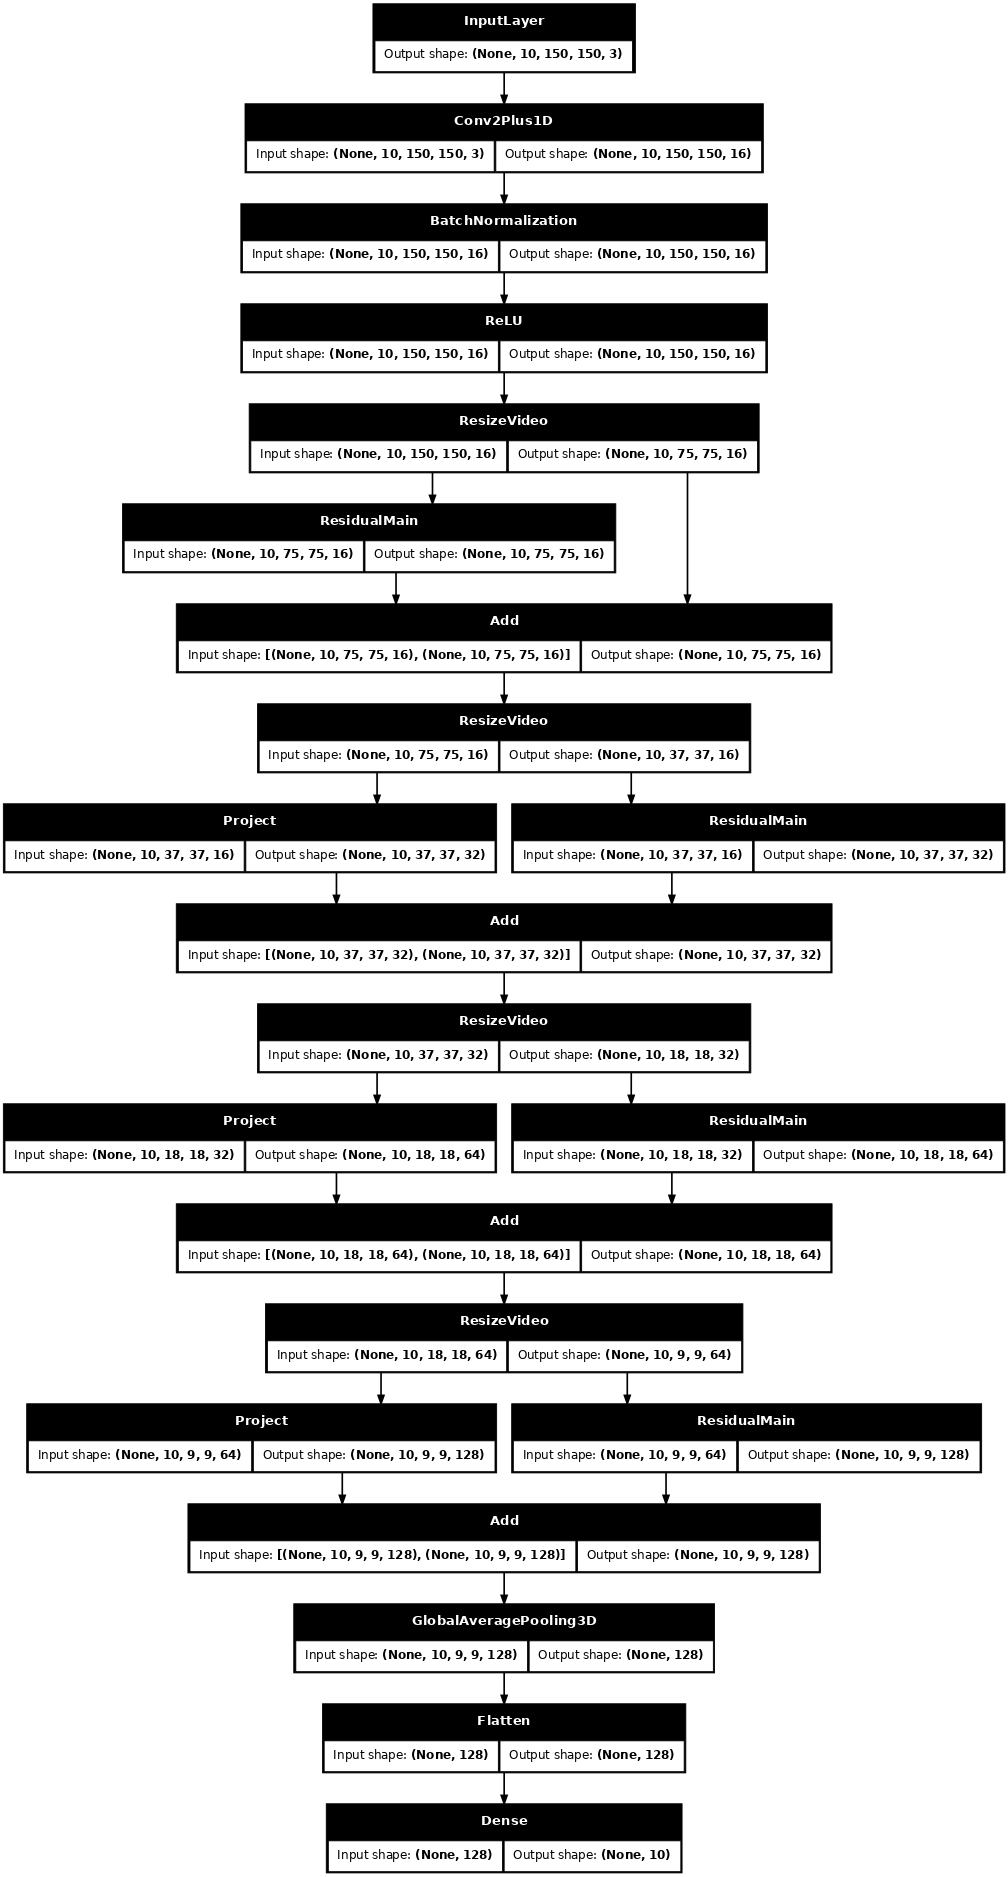

In [16]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [17]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [18]:
model.load_weights('asd.keras')

/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 138 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
history = model.fit(x = train_ds,
                    epochs = 10, 
                    validation_data = val_ds)

Epoch 1/10


I0000 00:00:1730095432.766264  545585 service.cc:145] XLA service 0x7f0ed000b970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730095432.766367  545585 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-10-28 11:33:53.021554: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-28 11:33:53.951561: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1730095436.574320  546821 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_29', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1730095437.009302  546820 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30', 1052 bytes spill stores, 1116 bytes spill loads

     57/Unknown 70s 757ms/step - accuracy: 0.7478 - loss: 0.7437

I0000 00:00:1730095498.999478  554560 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_29', 420 bytes spill stores, 396 bytes spill loads

I0000 00:00:1730095500.445762  554555 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30', 328 bytes spill stores, 316 bytes spill loads

2024-10-28 11:35:02.385264: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-28 11:35:04.809085: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were a

     58/Unknown 89s 1s/step - accuracy: 0.7475 - loss: 0.7437   

2024-10-28 11:35:15.746762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:35:15.746844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-28 11:35:15.746857: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762
/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-28 11:35:34.471650: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc)

58/58 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7472 - loss: 0.7437 - val_accuracy: 0.7606 - val_loss: 0.7234
Epoch 2/10


2024-10-28 11:35:36.638253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:35:36.638344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.7885 - loss: 0.6144

2024-10-28 11:36:22.272764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:36:22.272826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-28 11:36:22.272842: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762


58/58 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7882 - loss: 0.6145 - val_accuracy: 0.7394 - val_loss: 0.7472
Epoch 3/10


2024-10-28 11:36:39.676276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:36:39.676365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-28 11:36:39.676413: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.7644 - loss: 0.6558

2024-10-28 11:37:24.195210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:37:24.195295: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762
2024-10-28 11:37:24.195335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


58/58 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7643 - loss: 0.6559 - val_accuracy: 0.7660 - val_loss: 0.7328
Epoch 4/10


2024-10-28 11:37:40.393203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:37:40.393279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.8332 - loss: 0.5678

2024-10-28 11:38:25.420820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:38:25.420883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-28 11:38:25.420898: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762


58/58 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8326 - loss: 0.5682 - val_accuracy: 0.6809 - val_loss: 0.9497
Epoch 5/10


2024-10-28 11:38:42.355835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:38:42.355906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-28 11:38:42.355930: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4769205454797572833
2024-10-28 11:38:42.355962: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.8460 - loss: 0.4880

2024-10-28 11:39:27.561139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:39:27.561186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-28 11:39:27.561197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762


58/58 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8453 - loss: 0.4892 - val_accuracy: 0.6702 - val_loss: 0.9489
Epoch 6/10


2024-10-28 11:39:44.666814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:39:44.666878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-28 11:39:44.666892: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4769205454797572833
2024-10-28 11:39:44.666922: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.8289 - loss: 0.4867

2024-10-28 11:40:29.697935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:40:29.697982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-28 11:40:29.697992: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762


58/58 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8288 - loss: 0.4875 - val_accuracy: 0.7872 - val_loss: 0.7364
Epoch 7/10


2024-10-28 11:40:46.455682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:40:46.455772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.8674 - loss: 0.4911

2024-10-28 11:41:32.736482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:41:32.736527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-28 11:41:32.736538: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762


58/58 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8667 - loss: 0.4915 - val_accuracy: 0.7128 - val_loss: 0.8281
Epoch 8/10


2024-10-28 11:41:50.257250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:41:50.257360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-28 11:41:50.257376: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4769205454797572833
2024-10-28 11:41:50.257399: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.7805 - loss: 0.6187

2024-10-28 11:42:36.343362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:42:36.343417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-28 11:42:36.343451: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762


58/58 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7805 - loss: 0.6188 - val_accuracy: 0.7766 - val_loss: 0.6673
Epoch 9/10


2024-10-28 11:42:53.441230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:42:53.441337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.8462 - loss: 0.4625

2024-10-28 11:43:39.764888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:43:39.764949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-28 11:43:39.764964: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762


58/58 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8460 - loss: 0.4625 - val_accuracy: 0.7606 - val_loss: 0.5526
Epoch 10/10


2024-10-28 11:43:55.975809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:43:55.975911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.8344 - loss: 0.4639

2024-10-28 11:44:40.005227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:44:40.005285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-28 11:44:40.005300: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13068207209980883762


58/58 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8343 - loss: 0.4643 - val_accuracy: 0.8138 - val_loss: 0.5813


2024-10-28 11:44:56.074868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 11:44:56.074969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


In [24]:
model.save('asd.keras')

In [20]:
history.history

{'accuracy': [0.7294372320175171,
  0.7705627679824829,
  0.7597402334213257,
  0.798701286315918,
  0.8030303120613098,
  0.8181818127632141,
  0.826839804649353,
  0.7792207598686218,
  0.8333333134651184,
  0.8246753215789795],
 'loss': [0.7462413907051086,
  0.6249189376831055,
  0.6575160622596741,
  0.5908063650131226,
  0.5592353940010071,
  0.5349342226982117,
  0.5179768204689026,
  0.6202998757362366,
  0.4621540307998657,
  0.4885523319244385],
 'val_accuracy': [0.7606382966041565,
  0.7393617033958435,
  0.7659574747085571,
  0.6808510422706604,
  0.6702127456665039,
  0.7872340679168701,
  0.7127659320831299,
  0.7765957713127136,
  0.7606382966041565,
  0.813829779624939],
 'val_loss': [0.7234205603599548,
  0.7471638321876526,
  0.7327898144721985,
  0.9496687054634094,
  0.9488898515701294,
  0.7363871335983276,
  0.828109085559845,
  0.6672926545143127,
  0.5525911450386047,
  0.5813226103782654]}

In [21]:
data = history.history

def add_history(data):
    global history_data
    for i in history_data:
        history_data[i] += data[i]

add_history(data)

history_data

{'accuracy': [0.2142857164144516,
  0.31385281682014465,
  0.37012988328933716,
  0.4523809552192688,
  0.46536797285079956,
  0.5432900190353394,
  0.551948070526123,
  0.5757575631141663,
  0.6168830990791321,
  0.6082251071929932,
  0.6385281682014465,
  0.6515151262283325,
  0.6601731777191162,
  0.6839826703071594,
  0.7056276798248291,
  0.677489161491394,
  0.7294372320175171,
  0.7294372320175171,
  0.7186146974563599,
  0.738095223903656,
  0.7294372320175171,
  0.7705627679824829,
  0.7597402334213257,
  0.798701286315918,
  0.8030303120613098,
  0.8181818127632141,
  0.826839804649353,
  0.7792207598686218,
  0.8333333134651184,
  0.8246753215789795],
 'loss': [2.2236380577087402,
  1.9542049169540405,
  1.7800718545913696,
  1.5881649255752563,
  1.5647879838943481,
  1.381790041923523,
  1.31675386428833,
  1.2530393600463867,
  1.1656228303909302,
  1.1053072214126587,
  1.0417968034744263,
  1.0151253938674927,
  0.9698920249938965,
  0.9183856248855591,
  0.866548538208

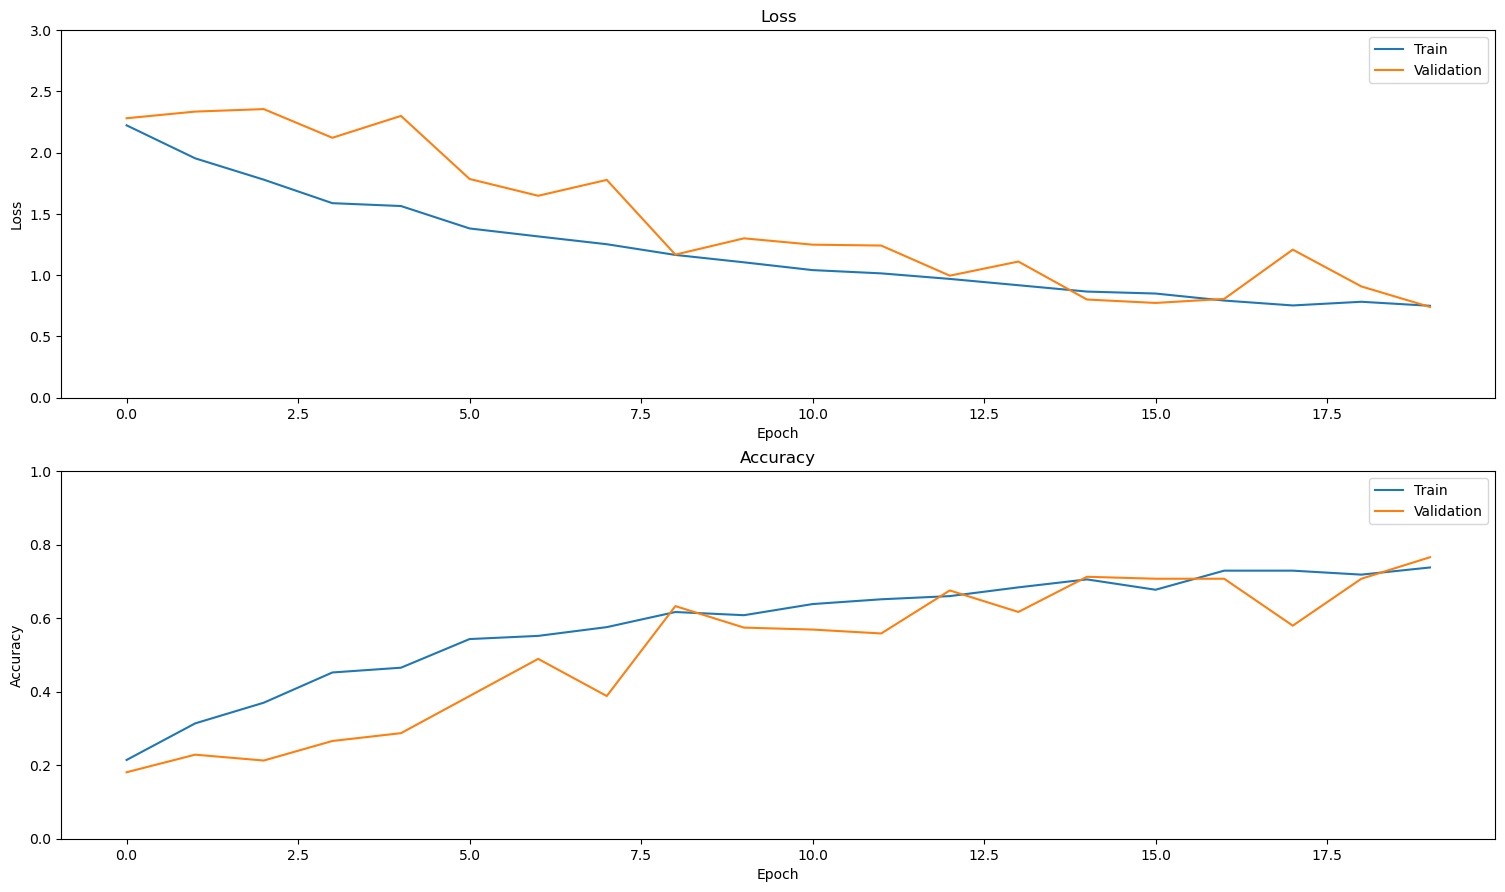

In [5]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history_data['loss'], label = 'train')
  ax1.plot(history_data['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history_data['loss'] + history_data['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history_data['accuracy'],  label = 'train')
  ax2.plot(history_data['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history_data)

In [21]:
model.evaluate(test_ds, return_dict=True)

     22/Unknown 15s 695ms/step - accuracy: 0.4593 - loss: 1.5668

2024-10-28 10:17:18.500224: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.90GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 888ms/step - accuracy: 0.4661 - loss: 1.5425


2024-10-28 10:17:20.933467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-28 10:17:20.933514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


{'accuracy': 0.5409836173057556, 'loss': 1.2755348682403564}

In [20]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [21]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [22]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())


      1/Unknown 3s 3s/step


      2/Unknown 3s 117ms/step


      3/Unknown 4s 481ms/step


      4/Unknown 5s 617ms/step


      5/Unknown 6s 693ms/step


      6/Unknown 7s 746ms/step


      7/Unknown 8s 770ms/step


      8/Unknown 9s 793ms/step


      9/Unknown 9s 800ms/step


     10/Unknown 11s 842ms/step


     11/Unknown 11s 825ms/step


     12/Unknown 12s 835ms/step


     13/Unknown 13s 833ms/step


     14/Unknown 14s 822ms/step


     15/Unknown 15s 820ms/step


     16/Unknown 15s 828ms/step


     17/Unknown 16s 829ms/step


     18/Unknown 17s 835ms/step


     19/Unknown 18s 834ms/step


     20/Unknown 19s 831ms/step


     21/Unknown 20s 828ms/step


     22/Unknown 20s 826ms/step


     23/Unknown 21s 832ms/step


     24/Unknown 22s 830ms/step


     25/Unknown 23s 832ms/step


     26/Unknown 24s 832ms/step


     27/Unknown 25s 831ms/step


     28/Unknown 26s 833ms/step


     29/Unknown 26s 837ms/step


     30/Unknown 27s 834ms/step


     31/Unknown 28s 835ms/step


     32/Unknown 29s 833ms/step


     33/Unknown 30s 836ms/step


     34/Unknown 31s 840ms/step


     35/Unknown 32s 843ms/step


     36/Unknown 33s 846ms/step


     37/Unknown 34s 847ms/step


     38/Unknown 36s 890ms/step


38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 890ms/step


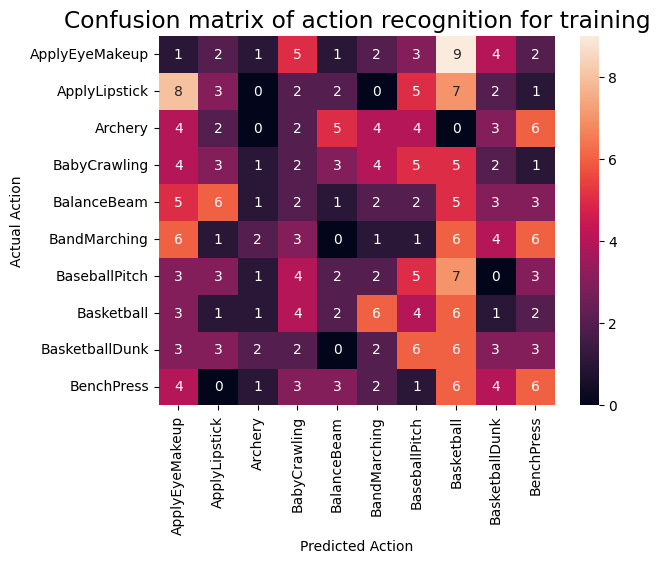

In [23]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')


      1/Unknown 1s 818ms/step


      2/Unknown 2s 1s/step   


      3/Unknown 3s 1s/step


      4/Unknown 4s 932ms/step


      5/Unknown 4s 914ms/step


      6/Unknown 5s 869ms/step


      7/Unknown 6s 865ms/step


      8/Unknown 7s 877ms/step


      9/Unknown 8s 896ms/step


     10/Unknown 9s 898ms/step


     11/Unknown 10s 913ms/step


     12/Unknown 11s 889ms/step


     13/Unknown 11s 841ms/step


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 841ms/step


/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


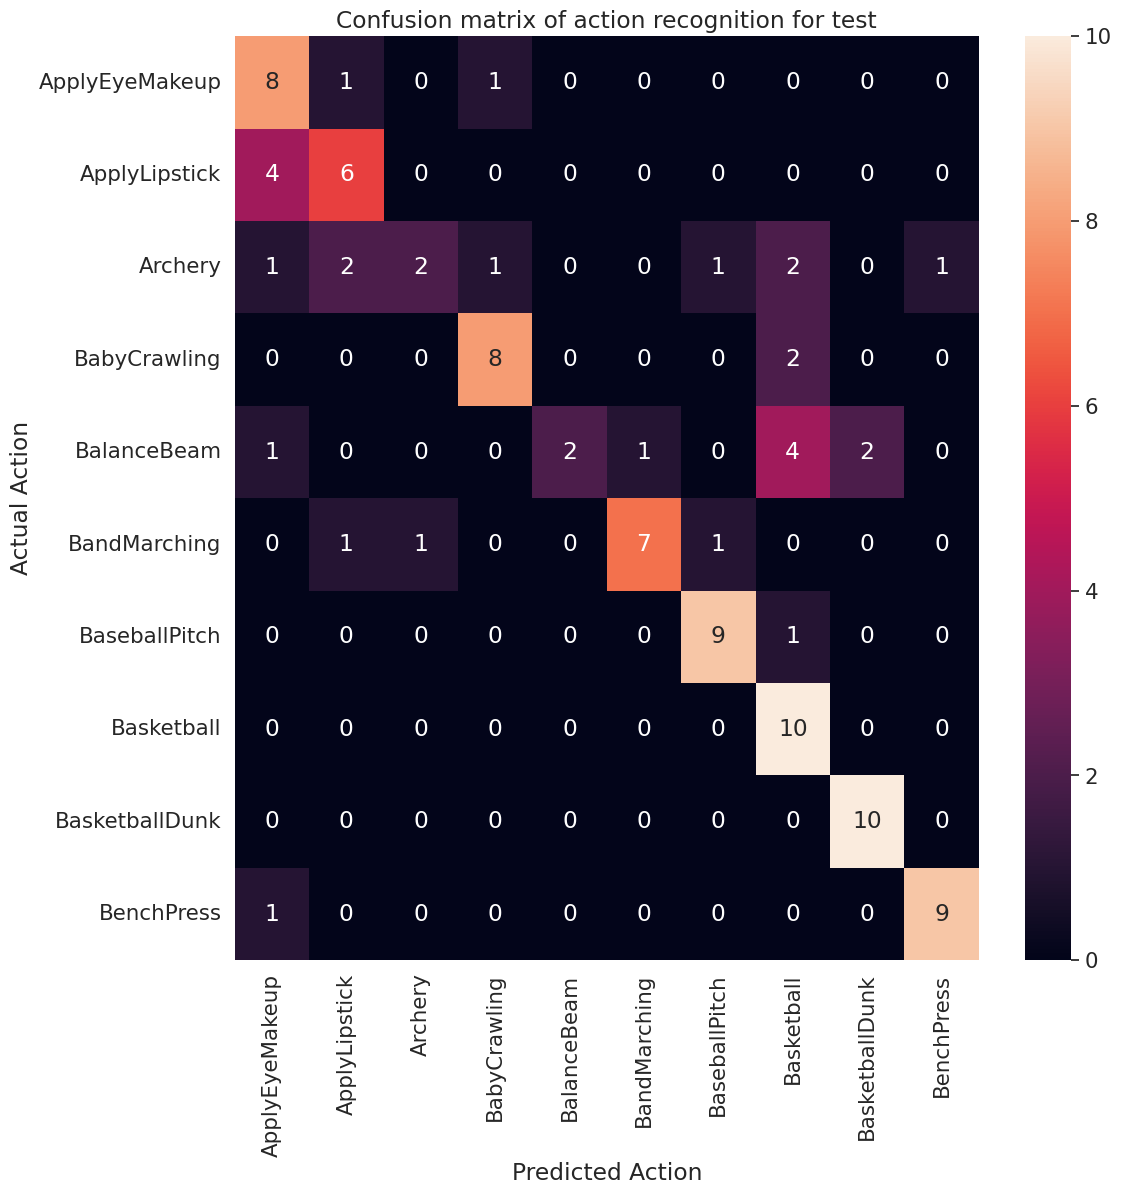

In [24]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

The precision and recall values for each class can also be calculated using a confusion matrix.

In [25]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [26]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [27]:
precision

{'ApplyEyeMakeup': 0.5333333333333333,
 'ApplyLipstick': 0.6,
 'Archery': 0.6666666666666666,
 'BabyCrawling': 0.8,
 'BalanceBeam': 1.0,
 'BandMarching': 0.875,
 'BaseballPitch': 0.8181818181818182,
 'Basketball': 0.5263157894736842,
 'BasketballDunk': 0.8333333333333334,
 'BenchPress': 0.9}

In [28]:
recall

{'ApplyEyeMakeup': 0.8,
 'ApplyLipstick': 0.6,
 'Archery': 0.2,
 'BabyCrawling': 0.8,
 'BalanceBeam': 0.2,
 'BandMarching': 0.7,
 'BaseballPitch': 0.9,
 'Basketball': 1.0,
 'BasketballDunk': 1.0,
 'BenchPress': 0.9}

## Next steps

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)